In [51]:
"""
    This script is to test captcha analysing
"""

'\n    This script is to test captcha analysing\n'

In [52]:
import io
import boto3
import logging
from pprint import pprint
from PIL import Image
import pytesseract
import re

In [53]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
session = boto3.Session()

In [54]:
def get_image_paths_from_s3(
    _s3_bucket_name: str,
    _s3_prefix: str,
    _session: boto3.Session
):
    """
        This function is to get image paths from s3
    """
    try:
        s3_client = _session.client('s3')
        s3_paginator = s3_client.get_paginator('list_objects_v2')
        s3_paginate_pages = s3_paginator.paginate(
            Bucket = _s3_bucket_name,
            Prefix = _s3_prefix
        )
        image_paths = []
        for index, s3_paginate_page in enumerate(s3_paginate_pages):
            temp_image_paths = []
            if index == 0:
                temp_image_paths = list(
                    map(
                        lambda _object: _object['Key'],
                        filter(
                            lambda _object: _object['Key'].endswith('png'),
                            s3_paginate_page['Contents']
                        )
                    )
                )
                image_paths += temp_image_paths
                break
        return image_paths
    except Exception as error:
        logger.error(error)
        raise ValueError('Error While Get Image Paths From S3.')

In [55]:
def load_image_from_s3_as_binary(
    _s3_bucket_name: str,
    _image_path: str,
    _session: boto3.Session
):
    """
        This function is to load image from s3 as binary
    """
    try:
        s3_resource = _session.resource('s3')
        image_object = s3_resource.Object(
            _s3_bucket_name,
            _image_path
        )
        image_stream = io.BytesIO()
        image_object.download_fileobj(image_stream)
        return image_stream
    except Exception as error:
        logger.error(error)
        raise ValueError('Error While Load Image From S3 As Binary.')

In [56]:
def image_binarization(
    _image: Image.Image,
    _threshold: int
):
    """
        This function is to process image binarization
    """
    try:
        image_gray = _image.convert('L')
        pixels = image_gray.load()
        for x in range(image_gray.width):
            for y in range(image_gray.height):
                if pixels[x, y] > _threshold:
                    pixels[x, y] = 255
                else:
                    pixels[x, y] = 0
        return image_gray
    except Exception as error:
        logger.error(error)
        raise ValueError('Error While Process Image Binarization.')

In [57]:
def interference_line(
    _image: Image.Image
):
    """
        This function is to process interference line
    """
    try:
        pixels = _image.load()
        for x in range(1, _image.width - 1):
            for y in range(1, _image.height - 1):
                count = 0
                if pixels[x, y - 1] > 245:
                    count = count + 1
                if pixels[x, y + 1] > 245:
                    count = count + 1
                if pixels[x - 1, y] > 245:
                    count = count + 1
                if pixels[x + 1, y] > 245:
                    count = count + 1
                if count > 2:
                    pixels[x, y] = 255
        return _image
    except Exception as error:
        logger.error(error)
        raise ValueError('Error While Process Interference Line.')

In [58]:
def interference_point(
    _image: Image.Image
):
    """
        This function is to process interference point
    """
    try:
        pixels = _image.load()
        for x in range(0, _image.width - 1):
            for y in range(0, _image.height - 1):
                cur_pixel = pixels[x, y]
                if y == 0:
                    if x == 0:
                        sum = int(cur_pixel) \
                            + int(pixels[x, y + 1]) \
                            + int(pixels[x + 1, y]) \
                            + int(pixels[x + 1, y + 1])
                        if sum <= 2 * 245:
                            pixels[x, y] = 0
                    elif x == _image.height - 1:
                        sum = int(cur_pixel) \
                            + int(pixels[x, y + 1]) \
                            + int(pixels[x - 1, y]) \
                            + int(pixels[x - 1, y + 1])
                        if sum <= 2 * 245:
                            pixels[x, y] = 0
                    else:
                        sum = int(pixels[x - 1, y]) \
                            + int(pixels[x - 1, y + 1]) \
                            + int(cur_pixel) \
                            + int(pixels[x, y + 1]) \
                            + int(pixels[x + 1, y]) \
                            + int(pixels[x + 1, y + 1])
                        if sum <= 3 * 245:
                            pixels[x, y] = 0
                elif y == _image.width - 1:
                    if x == 0:
                        sum = int(cur_pixel) \
                            + int(pixels[x + 1, y]) \
                            + int(pixels[x + 1, y - 1]) \
                            + int(pixels[x, y - 1])
                        if sum <= 2 * 245:
                            pixels[x, y] = 0
                    elif x == _image.height - 1:
                        sum = int(cur_pixel) \
                            + int(pixels[x, y - 1]) \
                            + int(pixels[x - 1, y]) \
                            + int(pixels[x - 1, y - 1])
                        if sum <= 2 * 245:
                            pixels[x, y] = 0
                    else:
                        sum = int(cur_pixel) \
                            + int(pixels[x - 1, y]) \
                            + int(pixels[x + 1, y]) \
                            + int(pixels[x, y - 1]) \
                            + int(pixels[x - 1, y - 1]) \
                            + int(pixels[x + 1, y - 1])
                        if sum <= 3 * 245:
                            pixels[x, y] = 0
                else:
                    if x == 0:
                        sum = int(pixels[x, y - 1]) \
                            + int(cur_pixel) \
                            + int(pixels[x, y + 1]) \
                            + int(pixels[x + 1, y - 1]) \
                            + int(pixels[x + 1, y]) \
                            + int(pixels[x + 1, y + 1])
                        if sum <= 3 * 245:
                            pixels[x, y] = 0
                    elif x == _image.height - 1:
                        sum = int(pixels[x, y - 1]) \
                            + int(cur_pixel) \
                            + int(pixels[x, y + 1]) \
                            + int(pixels[x - 1, y - 1]) \
                            + int(pixels[x - 1, y]) \
                            + int(pixels[x - 1, y + 1])
                        if sum <= 3 * 245:
                            pixels[x, y] = 0
                    else:
                        sum = int(pixels[x - 1, y - 1]) \
                            + int(pixels[x - 1, y]) \
                            + int(pixels[x - 1, y + 1]) \
                            + int(pixels[x, y - 1]) \
                            + int(cur_pixel) \
                            + int(pixels[x, y + 1]) \
                            + int(pixels[x + 1, y - 1]) \
                            + int(pixels[x + 1, y]) \
                            + int(pixels[x + 1, y + 1])
                        if sum <= 4 * 245:
                            pixels[x, y] = 0
        return _image
    except Exception as error:
        logger.error(error)
        raise ValueError('Error While Process Interference Point.')

In [59]:
def main():
    """
        This is main function
    """
    try:
        s3_bucket_name = ''
        s3_prefix = ''
        image_paths = get_image_paths_from_s3(
            s3_bucket_name,
            s3_prefix,
            session
        )
        count = 0
        for image_path in image_paths[:50]:
            # print(image_path)
            image_binary = load_image_from_s3_as_binary(
                s3_bucket_name,
                image_path,
                session
            )
            image = Image.open(image_binary)
            image_processed = image_binarization(
                image,
                254.5
            )
            # display(image_processed)
            image_with_interference_line_processed = interference_line(image_processed)
            # display(image_processed_1)
            image_with_interference_point_processed = interference_point(image_with_interference_line_processed)
            # display(image_processed_2)
            answer = pytesseract.image_to_string(
                image_with_interference_point_processed,
                # lang = 'eng',
                config = '--psm 8'
            )
            if re.match('[0-9]{4}', answer[:4]):
                # print(image_path)
                display(image)
                display(image_processed)
                display(answer[:4])
                count += 1
        # display(f'rate: {count} / 1000')
    except Exception as error:
        raise

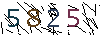

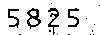

'5825'

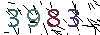

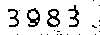

'3983'

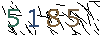

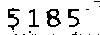

'5185'

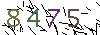

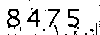

'8475'

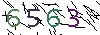

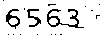

'6563'

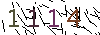

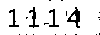

'1414'

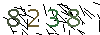

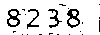

'8238'

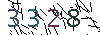

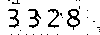

'3328'

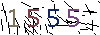

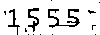

'4555'

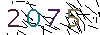

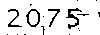

'2075'

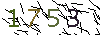

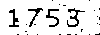

'4753'

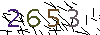

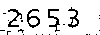

'2653'

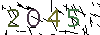

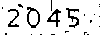

'2045'

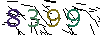

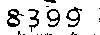

'8399'

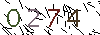

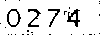

'0274'

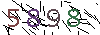

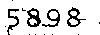

'5398'

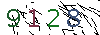

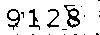

'9428'

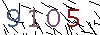

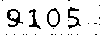

'9105'

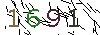

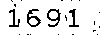

'1691'

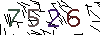

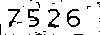

'7526'

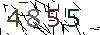

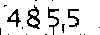

'4855'

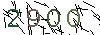

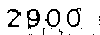

'2000'

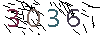

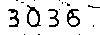

'3036'

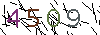

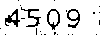

'4509'

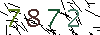

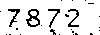

'7872'

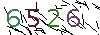

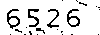

'6526'

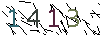

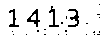

'1413'

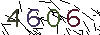

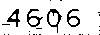

'4606'

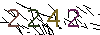

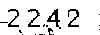

'2242'

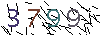

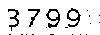

'3799'

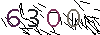

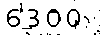

'6300'

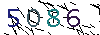

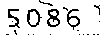

'5086'

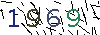

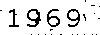

'1969'

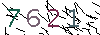

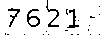

'7624'

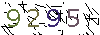

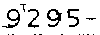

'9295'

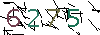

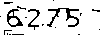

'6275'

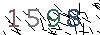

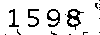

'1598'

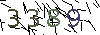

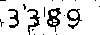

'3389'

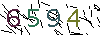

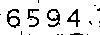

'6594'

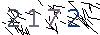

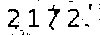

'2172'

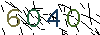

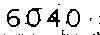

'6040'

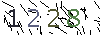

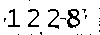

'1228'

In [60]:
if __name__ == '__main__':
    main()